<a href="https://colab.research.google.com/github/mkirby1995/DS-Unit-2-Sprint-1-Linear-Algebra/blob/master/module3-dimensionality-reduction/High_Dimensional_Data_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vertical Line Test

## 1.1 Create two graphs, one that passes the vertical line test and one that does not.

In [0]:
import matplotlib.pyplot as plt
import numpy as np

**Graph that passes vertical line test**

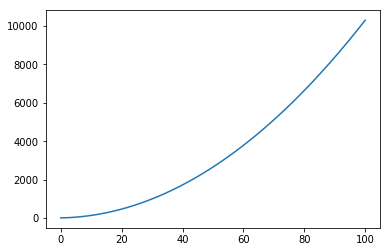

In [3]:
# Grid of 0.01 spacing from o to 100
x = np.arange(0, 100, .01) 
# Equation x^2 + 3x + 7
y = (x)**2 + (x) * 3 + 7

plt.plot(x, y)

plt.show();



---



**Graph that does not pass vertical line test**

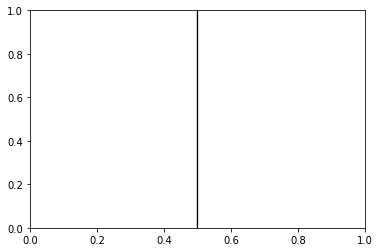

In [14]:
# Grid of 0.01 spacing from o to 100
x = np.arange(0, 100, .01) 

# Vertical line at x = .5
plt.arrow(.5,0,0,5)

plt.show();



---



## 1.2 Why are graphs that don't pass the vertical line test not considered "functions?"

Their inputs have more than one unique output



---



# Functions as Relations

## 2.1 Which of the following relations are functions? Why?

\begin{align}
\text{Relation 1: } \{(1, 2), (3, 2), (1, 3)\}
\\
\text{Relation 2: } \{(1, 3), (2, 3), (6, 7)\}
\\
\text{Relation 3: } \{(9, 4), (2, 1), (9, 6)\}
\\
\text{Relation 4: } \{(6, 2), (8, 3), (6, 4)\}
\\
\text{Relation 5: } \{(2, 6), (2, 7), (2, 4)\}
\end{align}

Only Relation 2, because its inputs generate a single unique output.



---



# Functions as a mapping between dimensions


## 3.1 for the following functions what is the dimensionality of the domain (input) and codomain (range/output)?

\begin{align}
m(𝑥_1,𝑥_2,𝑥_3)=(x_1+x_2, x_1+x_3, x_2+x_3)
\\
n(𝑥_1,𝑥_2,𝑥_3,𝑥_4)=(x_2^2 + x_3, x_2x_4)
\end{align}

**$m(x_1, x_2, x_3)$ Dimensionality**

- Input

  -3D
  
- Output

  -3D



---



**$n(𝑥_1,𝑥_2,𝑥_3,𝑥_4)$ Dimensionality**

- Input

  -4D
  
- Output

  -2D



---



## 3.2 Do you think it's possible to create a function that maps from a lower dimensional space to a higher dimensional space? If so, provide an example.

No, higher dimensional inputs can be mapped as lower dimensional outputs with transformations of the data, but lower dimensional inputs cannout become higher dimensional outputs.



---



# Vector Transformations

## 4.1 Plug the corresponding unit vectors into each function. Use the output vectors to create a transformation matrix.

\begin{align}
p(\begin{bmatrix}x_1 \\ x_2 \end{bmatrix}) = \begin{bmatrix} x_1 + 3x_2 \\2 x_2 - x_1 \\  \end{bmatrix}
\\
\\
q(\begin{bmatrix}x_1 \\ x_2 \\ x_3\end{bmatrix}) = \begin{bmatrix} 4x_1 + x_2 + 2x_3 \\2 x_2 - x_1 + 3x_3 \\ 5x_1 - 2x_3 + x_2  \end{bmatrix}
\end{align}

**T(p)**

In [0]:
def two_d_trans(vec):
  return np.array([[vec[0] + 3*vec[1]],
                   [2 * vec[1] - vec[0]]])

In [120]:
t_p = np.array([[1,3],
          [-1, 2]])
t_p

array([[ 1,  3],
       [-1,  2]])



---



**T(q)**

In [0]:
def three_d_trans(vec):
  return np.array([[4*vec[0] + vec[1] + 2*vec[2]],
                   [2 * vec[1] - vec[0] + 3*vec[2]],
                   [5*vec[0] - 2*vec[2] + vec[1]]])

In [121]:
t_q = np.array([[4,1,2],
          [-1,2,3],
          [5,1,2]])
t_q

array([[ 4,  1,  2],
       [-1,  2,  3],
       [ 5,  1,  2]])



---



## 4.2 Verify that your transformation matrices are correct by choosing an input matrix and calculating the result both via the traditional functions above and also via vector-matrix multiplication.

**Check p**

In [0]:
input_a = np.array([3,4])

In [128]:
two_d_trans(input_a)

array([[15],
       [ 5]])

In [131]:
np.matmul(t_p, input_a)

array([15,  5])



---



**Check q**

In [0]:
input_b = np.array([3, 4, 5])

In [133]:
three_d_trans(input_b)

array([[26],
       [20],
       [ 9]])

In [134]:
np.matmul(t_q, input_b)

array([26, 20, 29])



---



# Eigenvalues and Eigenvectors

## 5.1 In your own words, give an explanation for the intuition behind eigenvalues and eigenvectors.

An eigenvector is a vector that does not reorient when the 3D space containing it is transformed.

The eigenvector does not reorient, but it can be streched or squished. The eigenvalue is the scalar on the eigenvector that represents this streching or squishing.



---



# The Curse of Dimensionality

## 6.1 What are some of the challenges of working with high dimensional spaces?

Higher dimensional spaces are hard to conceptualize, and visualize.



---



## 6.2 What is the rule of thumb for how many observations you should have compared to parameters in your model?

5x more obsrvations than features



---



# Principal Component Analysis

## 7.1 Load the UCI Machine Learning Repository's [Iris Dataset](https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv) and use PCA to isolate the dataset's first and second principal components and plot them on a graph. 

**Import Data**

In [0]:
import pandas as pd
import numpy as np

In [0]:
df = pd.read_csv('https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/d546eaee765268bf2f487608c537c05e22e4b221/iris.csv')

In [76]:
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,species
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica




---



**Standardize Data**

In [0]:
from sklearn.preprocessing import StandardScaler

features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [88]:
x = df.loc[:, features].values
x[0:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [90]:
y = df.loc[:,['species']].values
y[0:5]

array([['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa']], dtype=object)

In [92]:
x = StandardScaler().fit_transform(x)
x[0:5]

array([[-0.90068117,  1.03205722, -1.3412724 , -1.31297673],
       [-1.14301691, -0.1249576 , -1.3412724 , -1.31297673],
       [-1.38535265,  0.33784833, -1.39813811, -1.31297673],
       [-1.50652052,  0.10644536, -1.2844067 , -1.31297673],
       [-1.02184904,  1.26346019, -1.3412724 , -1.31297673]])



---



**PCA On Sepal and Petals**

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [99]:
princ_comps = pca.fit_transform(x)
principalDf = pd.DataFrame(data = princ_comps,
                           columns = ['Sepals', 'Petals'])
principalDf.head()

,Sepals,Petals
0,-2.264542,0.505704
1,-2.086426,-0.655405
2,-2.367950,-0.318477
3,-2.304197,-0.575368
4,-2.388777,0.674767


In [102]:
final_df = pd.concat([principalDf, df['species']], axis=1)
final_df.head()

,Sepals,Petals,species
0,-2.264542,0.505704,setosa
1,-2.086426,-0.655405,setosa
2,-2.367950,-0.318477,setosa
3,-2.304197,-0.575368,setosa
4,-2.388777,0.674767,setosa




---



**Plot**

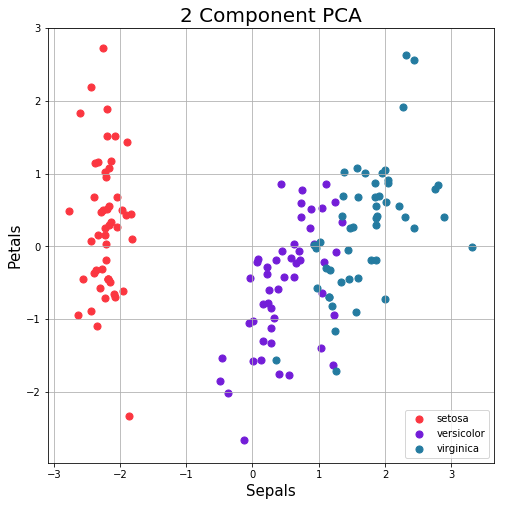

In [115]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)


ax.set_xlabel('Sepals', fontsize = 15)
ax.set_ylabel('Petals', fontsize = 15)


ax.set_title('2 Component PCA', fontsize = 20)


targets = ['setosa', 'versicolor', 'virginica']
colors = ['#FB3640', '#731DD8', '#247BA0']


for target, color in zip(targets,colors):
    indicesToKeep = final_df['species'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'Sepals']
               , final_df.loc[indicesToKeep, 'Petals']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()



---



# Stretch Goal

## 1) Do NOT work on the stretch goal until you feel like you have a firm grasp of eigenvectors, eigenvalues, and PCA. Prioritize self-study over the stretch goal if you are not comfortable with those topics yet.

## 2) Explore further the intuition behind eigenvalues and eigenvectors by creating your very own eigenfaces:

<center>![Eigenfaces](https://i.pinimg.com/236x/1c/f1/01/1cf101a9859437a5d096a04b05be06b4--faces-tattoo.jpg)</center>

You don't necessarily have to use this resource, but this will get you started: 
[Eigenface Tutorial](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)